In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
from astropy.time import Time
import lightkurve as lk
from matplotlib.collections import LineCollection
from tqdm import tqdm_notebook

import glob, os

from astropy.table import Table
plt.rcParams['font.size'] = 20

In [2]:
from scripts import *

In [3]:
targets2 = Table.read('m_dwarf_dections_27_03_20_correct_fluxes.fits')

In [4]:
targets2['common_name']

GJ 412
LP 212-62
LP 169-22
GJ 3789
GJ 1151
2MASS J09481615+5114518
2MASS J10534129+5253040
G 240-45
GJ 3729
GJ 3861
GJ 9552


In [5]:
targets = Table.read('names_best_cands_4sig_stokesv_clean_leakage_gaia_propermotion_applied stars_added_2019_10_24.fits')
names = targets['common_name']
name = 'CR Dra'
name = names[2].strip()
name = '44 Boo'
name= 'GJ 1151'
name='CR Dra'
name = 'HAT 182-00605' 
name='TIC 453430899'

stars_simultaneous = {'GJ 450':'2020-03-16T20:11:00',
         'GJ 3861':'2020-02-19T23:57:00',
         '2MASS J09481615+5114518':'2020-01-31T20:45:40',
         'LP 212-62':'2020-02-04T20:48:20'}
stars_simultaneous = {'EW Dra': '2020-04-02T22:55:34',
                      'HD 233153': '2019-12-12T19:41:00',
                      'HD 37394':'2019-12-12T19:41:00',
                      'Tau Boo': '2019-07-06T14:26:09',
                      'Wolf 1069': '2019-08-05T19:05:52',
                      'Ross 567': '2019-11-28T20:11:00',
                      'G262-15': '2019-08-17T18:06:56',
                      'UCAC4 642-113039':'2019-09-26T17:09:42',
                      'G258-33':'2019-11-10T10:48:00',
                      'G 227-22':'2019-11-10T10:48:00',
                      'IRAS21500+5903':'2019-09-18T18:11:00',
                      '54 Psc':'2019-10-19T18:11:00',
                      'HD 10780':'2019-11-03T18:31:10',
                      'UCAC4 655-108663': '2019-10-05T17:11:00',
                      'HD 223778 B': '2019-11-20T17:11:00'

}


whichstar = 1
name = list(stars_simultaneous.keys())[whichstar]
name = 'HD 223778 B'
# name = 'G 227-22'
name = 'HD 233153'

# name = 'EW Dra'
date = stars_simultaneous[name]
# name='WX Uma'
# name = 'Ross 867'
# name = 'UCAC4 444-118477'

In [6]:
list(stars_simultaneous.keys())

['EW Dra',
 'HD 233153',
 'HD 37394',
 'Tau Boo',
 'Wolf 1069',
 'Ross 567',
 'G262-15',
 'UCAC4 642-113039',
 'G258-33',
 'G 227-22',
 'IRAS21500+5903',
 '54 Psc',
 'HD 10780',
 'UCAC4 655-108663',
 'HD 223778 B']

In [11]:
search=lk.search_lightcurvefile(name,radius=95.0)

In [12]:
search

#,observation,target_name,productFilename,distance
0,TESS Sector 19,311063391,tess2019331140908-s0019-0000000311063391-0164-s_lc.fits,92.99546716497068


In [13]:
tics, time, flux, errs, sects, data_all = load_lightcurve(name,radius=95.)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


In [14]:
period = get_rotation_period(tics,time,flux,errs)
print(period)

Finding most likely periods: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


5.649057909846834


In [15]:
avg_preds = run_cnn(tics,time,flux,errs)

Can only use stella.ConvNN.predict().


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


In [16]:
flare_table = get_flares(tics,time,flux,avg_preds,errs)
flare_table.write('flares_%s.csv' % (name.replace(' ','_').lower()),format='ascii')

Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00, 3560.53it/s]


In [17]:
flare_rate = get_flare_rate(time,flare_table)
print(flare_rate)

0.0 1 / d


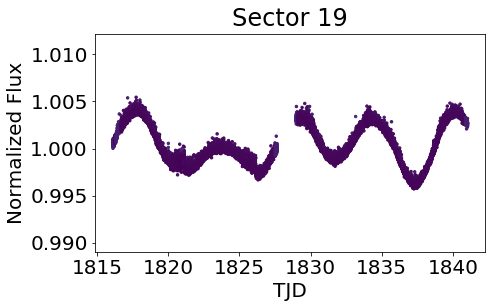

In [18]:
groups,sectors = group_sectors(data_all)
ngroups = len(groups)
width_ratios = [len(group) for group in groups] 
fig, axes = plt.subplots(ncols=ngroups, figsize=(ngroups*7,4),
                           sharey=True, gridspec_kw={'width_ratios':width_ratios})
for j, g in enumerate(groups):
    if len(groups)>1:
        ax = axes[j]
    else:
        ax = axes
    if j == 0:
        ax.set_ylabel('Normalized Flux')
    for i in g:
        ax.scatter(time[i], flux[i], c=avg_preds[i],
                    vmin=0, vmax=1, s=6)
    if len(g)==1:
        ax.set_title('Sector '+str(sectors[g[0]]),y=1.01)
    else:
        ss = [sectors[s] for s in g]
        ax.set_title('Sectors ' + ", ".join([str(s) for s in ss]),y=1.01)
    ax.set_xlabel('TJD')
yrange = np.percentile(np.hstack(flux),(2,50,98))
lims = (yrange[1]-1.0*(yrange[2]-yrange[0]), yrange[1]+1.0*(yrange[2]-yrange[0]))
# plt.ylim(*lims)
plt.subplots_adjust(wspace=0.1)
plt.savefig('results/flare_lc_%s_nozoom.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

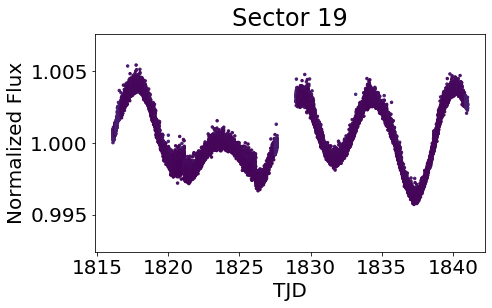

In [19]:
do_plots(tics,time,flux,avg_preds,errs,data_all)
plt.savefig('results/flare_lc_%s.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

In [20]:
dates_all = [lk.btjd_to_astropy_time(t) for t in time]
for j in range(len(dates_all)):
    print(dates_all[j].min().decimalyear,dates_all[j].max().decimalyear)

2019.9084631715748 2019.9767934844026


In [21]:
final = data_all[-1]

In [22]:
lk.btjd_to_astropy_time(final.time).datetime64

array(['2019-11-28T14:08:14.578783214', '2019-11-28T14:10:14.582960308',
       '2019-11-28T14:12:14.587137401', ...,
       '2019-12-23T15:36:39.221022427', '2019-12-23T15:38:39.219848514',
       '2019-12-23T15:40:39.218634367'], dtype='datetime64[ns]')

In [23]:
tstart = date

t = Time(tstart, format='isot', scale='utc')

print(t.decimalyear)

2019.947452435312


In [24]:
np.hstack(time)

array([1816.08905762, 1816.09044656, 1816.0918355 , ..., 1841.02684406,
       1841.02823293, 1841.02962181])

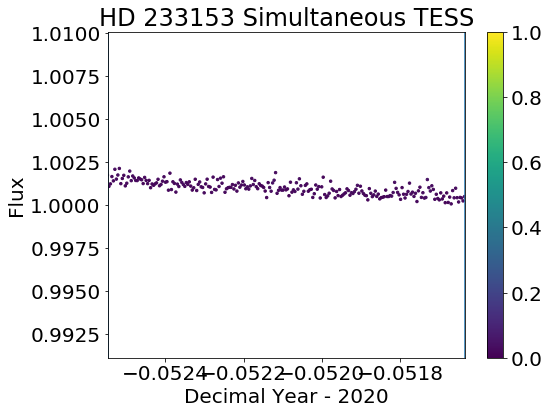

In [30]:
from astropy.time import Time, TimeDelta

dates = lk.btjd_to_astropy_time(np.hstack(time))

# tstart = '2020-05-15T20:11:00'
tstart = date
t = Time(tstart, format='isot', scale='utc')
dt = TimeDelta(3600.*8., format='sec')
tfinish = t+dt

fig = plt.figure(figsize=(8.0,6.0))
plt.scatter(dates.decimalyear-2020,np.hstack(flux),c=np.hstack(avg_preds),
                    vmin=0, vmax=1, s=6)
# plt.xlim(t.decimalyear-2020,tfinish.decimalyear-2020)
plt.axvline(t.decimalyear-2020)
plt.axvline(tfinish.decimalyear-2020)
plt.xlabel('Decimal Year - 2020')
plt.ylabel('Flux')
# plt.ylim(0.98,1.01)
plt.xlim(t.decimalyear-2020,tfinish.decimalyear-2020)
plt.colorbar()
plt.title(name+' Simultaneous TESS')
savename= (name.replace(' ','_').lower())
plt.savefig('results/%s_simultaneous.png' %  savename,bbox_inches='tight')

In [26]:
data_all[0].targetid

311063391

In [27]:
dates.shape

(16731,)

In [28]:
f = open('results/%s_output.txt' % (name.replace(' ','_').lower()),'w')
f.write('%s\n%f\n%f\n' % (name,period,flare_rate.value))
f.close()

In [29]:
savedir = 'results/'

saved_files = glob.glob(savedir+'*')


In [ ]:
# saved_files